In [4]:
!!echo "# Project_codestates" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/nywook/Project_codestates.git
!git push -u origin main

Initialized empty Git repository in /content/.git/

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@27163deb330e.(none)')
error: refname refs/heads/master not found
fatal: Branch rename failed
error: src refspec main does not match any.
error: failed to push some refs to 'https://github.com/nywook/Project_codestates.git'


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import re

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install squarify


import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/S1/GR.csv', index_col=0)
df.dropna(inplace=True)

In [ ]:
#df.head()
df1.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [ ]:
df.info()

In [ ]:
import missingno as msno
msno.matrix(df, figsize=(18,6))

#### 1.Data PreProcessing
##### 1.1 판매실적 (k & m)

In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

In [ ]:
num_col = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
for col in num_col:
  counts = df[col].str.extract('([a-zA-Z])', expand = False).value_counts() # K와 M의 개수확인
  print("column : {0}\n{1}\n".format(col, counts))

column : NA_Sales
M    97
K    94
Name: NA_Sales, dtype: int64

column : EU_Sales
K    98
M    97
Name: EU_Sales, dtype: int64

column : JP_Sales
K    98
M    98
Name: JP_Sales, dtype: int64

column : Other_Sales
M    100
K     97
Name: Other_Sales, dtype: int64



In [ ]:
cond_M = (df['EU_Sales'].str.extract('([a-zA-Z])', expand = False) == 'M')
df['EU_Sales'][cond_M].apply(lambda x: re.sub("([a-zA-Z])","",x)).astype(float)

10       0.33
35       0.03
173      0.01
214      0.01
452      0.27
         ... 
15817    0.01
15918    0.05
15995    0.00
16032    0.04
16215    0.00
Name: EU_Sales, Length: 97, dtype: float64

In [ ]:
for col in num_col:
  cond_k = (df[col].str.extract('([a-zA-Z])', expand = False) == 'K') # K의 단위를 가진 데이터
  cond_m = (df[col].str.extract('([a-zA-Z])', expand = False) == 'M') # M의 단위를 가진 데이터

  # 알파벳 "K" 삭제 및 단위맞추기
  df[col][cond_k] = df[col][cond_k].apply(lambda x: re.sub("([a-zA-Z])","",x)).astype(float)
  df[col][cond_k] = df[col][cond_k]/1000 # Convert a unit

  # 알파벳 "M" 삭제
  df[col][cond_m] = df[col][cond_m].apply(lambda x: re.sub("([a-zA-Z])","",x)).astype(float)
  
  # Float으로 변경
  df[col] = df[col].astype(float)

In [ ]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04


##### 1.2 년도 전처리

In [ ]:
df['Year'].value_counts()

2009.0    1418
2008.0    1413
2010.0    1246
2007.0    1192
2011.0    1123
          ... 
12.0         2
97.0         2
94.0         1
2020.0       1
86.0         1
Name: Year, Length: 62, dtype: int64

In [ ]:
# 1000이하 데이터 확인Check all values less than 1000
cond_1000 = (df['Year'] < 1000)
df['Year'][cond_1000].value_counts()

9.0     10
8.0     10
11.0    10
3.0      7
6.0      7
10.0     7
15.0     5
16.0     5
4.0      4
5.0      4
95.0     4
7.0      3
98.0     3
0.0      3
2.0      3
96.0     3
14.0     2
97.0     2
1.0      2
13.0     2
12.0     2
86.0     1
94.0     1
Name: Year, dtype: int64

In [ ]:
cond_1000 = (df['Year'] < 1000)
df['Year'][cond_1000] = df['Year'][cond_1000].apply(lambda x: x + 2000 if x < 21 else x + 1900)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
np.sort(df['Year'].unique())

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016., 2017., 2020.])

In [ ]:
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

##### 1.3 genre 와 Publisher

In [ ]:
publisher_na =  ( df['Publisher'].isnull() )
genre_na =  ( df['Genre'].isnull() )

# NA 데이터 확인
both_na =  ( publisher_na & genre_na )
df[both_na]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales


##### 1.4 플랫폼

In [ ]:
df['Platform'].value_counts()

DS      2127
PS2     2121
PS3     1299
Wii     1284
X360    1231
PSP     1193
PS      1185
PC       935
XB       799
GBA      784
GC       541
3DS      498
PSV      409
PS4      335
N64      313
SNES     239
XOne     212
SAT      173
WiiU     143
2600     115
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: Platform, dtype: int64

In [ ]:
# 플롯폼별 게임운영개수
df1 = df[['Year', 'Platform']]
df1_not_na = df1[-df1.isnull()].reset_index()
df1_not_na.drop('index',axis = 1, inplace = True)

df1_not_na.head()

,Year,Platform
0,2008.0,DS
1,2009.0,Wii
2,2010.0,PSP
3,2010.0,DS
4,2010.0,PS3


In [ ]:
# 10년단위 플랫폼별 게임개수
## 2010 ~ 2020
cond_2020 = ( (df1_not_na['Year'] <= 2020) & (df1_not_na['Year'] > 2010) )
df1_2020 = df1_not_na[cond_2020].reset_index()
df1_2020.drop('index', axis = 1, inplace = True)

## Platform
platform_2020 = df1_2020['Platform'].value_counts().index.tolist()


#-----------------------------------------------------------------------------#

## 2000 ~ 2010
cond_2010 = ( (df1_not_na['Year'] <= 2010) & (df1_not_na['Year'] > 2000) )
df1_2010 = df1_not_na[cond_2010].reset_index()
df1_2010.drop('index', axis = 1, inplace = True)

## Platform
platform_2010 = df1_2010['Platform'].value_counts().index.tolist()

#-----------------------------------------------------------------------------#

## ~ 2000
cond_2000 = (df1_not_na['Year'] <= 2000)
df1_2000 = df1_not_na[cond_2000].reset_index()
df1_2000.drop('index', axis = 1, inplace = True)

## Platform
platform_2000 = df1_2000['Platform'].value_counts().index.tolist()

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15,18))

# X and Y 축
## 타이틀
title_font = {
    'family': 'monospace',
    'color':  'black',
    'fontsize': 30,
    'fontweight': 'bold'
}

## 텍스트
text_font = {
    'family': 'monospace',
    'color':  'black',
    'weight': 'bold',
    'size': 18,
    }


sns.boxplot(x = 'Platform', y = 'Year', data = df1_2020, ax = axes[0])
axes[0].set_title("Platform : 2010 ~ 2017", fontdict = title_font)
axes[0].set_xlabel('Platform', fontdict = text_font)
axes[0].set_ylabel('Year', fontdict = text_font)
axes[0].grid(True)

sns.boxplot(x = 'Platform', y = 'Year', data = df1_2010, ax = axes[1])
axes[1].set_title("Platform : 2000 ~ 2010",fontdict = title_font)
axes[1].set_xlabel('Platform', fontdict = text_font)
axes[1].set_ylabel('Year', fontdict = text_font)
axes[1].grid(True)

sns.boxplot(x = 'Platform', y = 'Year', data = df1_2000, ax = axes[2])
axes[2].set_title("Platform : ~ 2000",fontdict = title_font)
axes[2].set_xlabel('Platform', fontdict = text_font)
axes[2].set_ylabel('Year', fontdict = text_font)
axes[2].grid(True)

plt.subplots_adjust(hspace= 0.3)

plt.show()

In [ ]:
# 연도별 가장 많은 Platform
list_mode = pd.DataFrame( df[['Platform', 'Year']].groupby('Platform').agg(lambda x:x.value_counts().index[0]) )
dic_list_mode = list_mode.to_dict()
dic_list_mode = dic_list_mode['Year']
pd.DataFrame(list(dic_list_mode.items()), columns = ['Platform', 'Year']).head(10)

,Platform,Year
0,2600,1981.0
1,3DO,1995.0
2,3DS,2011.0
3,DC,2000.0
4,DS,2008.0
5,GB,2000.0
6,GBA,2002.0
7,GC,2002.0
8,GEN,1994.0
9,GG,1992.0


In [ ]:
df['Year'] = df['Year'].astype(int)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04


In [ ]:
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

In [ ]:
df['T_Sales'] = df[num_col].sum(axis = 1)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,T_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


#### 2.1 지역별 선호게임장르

In [ ]:
# X and Y 축
## Title
font_title = {'family': 'monospace',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
## Text
font_text = {
    'family': 'monospace',
    'color':  'black',
    'weight': 'bold',
    'size': 10,
    }


# Plotting
genre_list = df['Genre'].value_counts().index.to_list()
for gr in genre_list:
  cond_genre = (df['Genre'] == gr)
  df[cond_genre].groupby(by = 'Year')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum().plot(legend = True)

  
  # Text
  plt.title(gr, fontdict= font_title)
  plt.ylabel("Total Sales (in million)", fontdict= font_text)
  plt.xlabel("Year",fontdict = font_text) 

  # Background
  plt.grid(True)
  plt.show()

##### 2.2 연도별 게임장르 판매량

In [ ]:
genre_list = df['Genre'].value_counts().index.to_list()
fig, ax = plt.subplots(figsize = (16,8))

# Top 3 Highest Genre
top3 = ['Action', 'Shooter', 'Sports']

# Plotting
for gr in genre_list:
  gr_cond = (df['Genre'] == gr)
  # Gradient Line
  if gr in top3:
    alpha = 5
  else:
    alpha = 0.2
  # Line plot
  plt.plot('Year','T_Sales',data =  pd.DataFrame(df[gr_cond].groupby(by = ['Year'])[['T_Sales']].sum()).reset_index(), label = gr, alpha = alpha)



# X and Y 축
## Title
font_title = {'family': 'monospace',
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }
ax.set_title("Game Genre: Total Sales", fontdict = font_title)


## Text
font_text = {
    'family': 'monospace',
    'color':  'black',
    'weight': 'bold',
    'size': 16,
    }

plt.ylabel("Total Sales (in million)", fontdict = font_text)
plt.xlabel("Year",fontdict = font_text)



# Background
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Apex of Video Game Industry
ax.axvline(x = 2007, linewidth=1, color='r', linestyle = '-.')
ax.axvline(x = 2017, linewidth=1, color='r', linestyle = '-.')


ax.grid(True)
ax.set_facecolor('#E0E0E0')
plt.legend()
fig.tight_layout()
plt.show()

In [ ]:
non_action_list = ['Role-Playing', 'Simulation', 'Strategy', 'Puzzle', 'Misc', 'Adventure']
fig, ax = plt.subplots(figsize = (16,8))
for nac in non_action_list:
  nac_cond = (df['Genre'] == nac)
  plt.plot('Year','T_Sales',data =  pd.DataFrame(df[nac_cond].groupby(by = ['Year'])[['T_Sales']].sum()).reset_index(), label = nac)

# X and Y 축
ax.set_title("Total Sales in Other Genre", size = 20)
plt.ylabel("Total Sales (in million)")
plt.legend()


# Background
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.grid(True)
ax.set_facecolor('#E0E0E0')

plt.show()




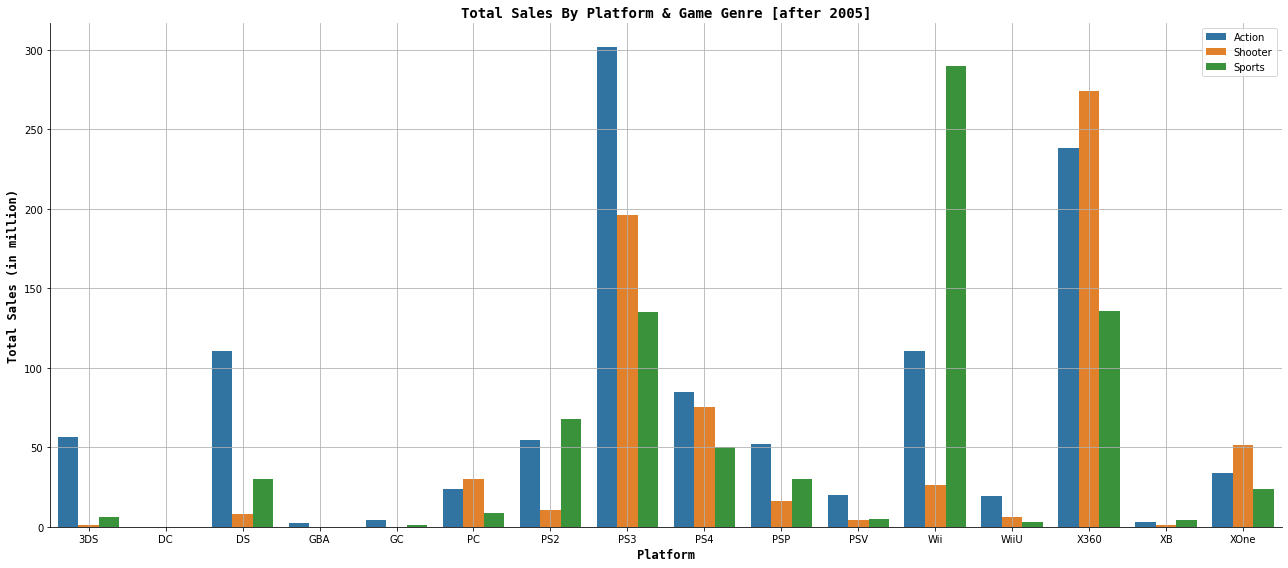

In [ ]:
# Top 3 Highest Genre in global in 2010's
top3 = ['Action', 'Shooter', 'Sports']
yr = 2005
yr_cond = (df['Year'] > yr)
top3_data = pd.DataFrame(df[yr_cond].groupby(by = ['Platform','Genre'])[['T_Sales']].sum()).reset_index()
# Selecting Top 3 Genre
top3_data = top3_data[top3_data['Genre'].isin(top3)]

# Platform 
fig, ax = plt.subplots(figsize = (18,8))
sns.barplot(x = 'Platform', y = 'T_Sales', data = top3_data, hue = 'Genre')

# X and Y 축
## Title
font_title = {'family': 'monospace',
        'color':  'black',
        'weight': 'bold',
        'size': 14,
        }
ax.set_title("Total Sales By Platform & Game Genre [after 2005]", fontdict = font_title)


## Text
font_text = {
    'family': 'monospace',
    'color':  'black',
    'weight': 'bold',
    'size': 12,
    }

plt.ylabel("Total Sales (in million)", fontdict = font_text)
plt.xlabel("Platform",fontdict = font_text)



# Background
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.grid(True)
ax.set_facecolor('white')
plt.legend()
fig.tight_layout()
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


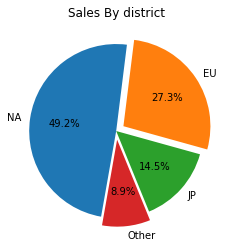

In [ ]:
#지역-장르별 매출현황
df2 = df.copy()

df_g = df2.groupby(['Genre'],as_index=False)['NA_Sales','EU_Sales','JP_Sales','Other_Sales','T_Sales'].sum()

na_sum = df2['NA_Sales'].sum()
eu_sum = df2['EU_Sales'].sum()
jp_sum = df2['JP_Sales'].sum()
ot_sum = df2['Other_Sales'].sum()
to_sum = df2['T_Sales'].sum()

import matplotlib.pyplot as plt

ratio = [na_sum,eu_sum,jp_sum,ot_sum]
labels = ['NA', 'EU', 'JP', 'Other']
explode = [0, 0.10, 0, 0.10]
plt.title('Sales By district')


plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode)
plt.show()


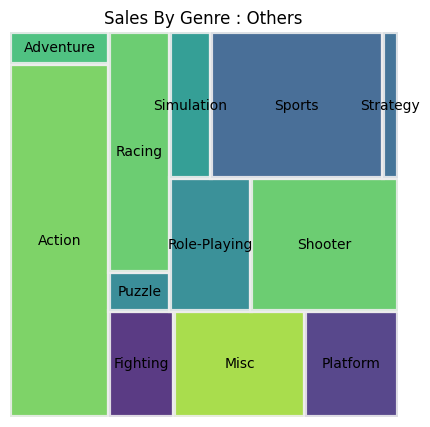

In [ ]:
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd

plt.style.use('default')
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 10

squarify.plot(sizes=df_g['Other_Sales'], label=df_g['Genre'], alpha=0.9, linestyle='solid', bar_kwargs=dict(linewidth=3, edgecolor="#eee"))

plt.title('Sales By Genre : Others')
plt.axis('off')
plt.show()

#'NA_Sales','EU_Sales','JP_Sales','Other_Sales'

In [ ]:
sortdf = df2.sort_values(by=['T_Sales'], ascending=False)
top_game_sale = sortdf.head(20)
top_game_sale = top_game_sale[['Name', 'Year', 'Genre','Publisher', 'T_Sales']]
top_game_sale = top_game_sale.sort_values(by=['T_Sales'], ascending=False)
top_game_sale = top_game_sale.reset_index(drop=True)
top_game_sale

,Name,Year,Genre,Publisher,T_Sales
0,Wii Sports,2006,Sports,Nintendo,82.74
1,Super Mario Bros.,1985,Platform,Nintendo,40.24
2,Mario Kart Wii,2008,Racing,Nintendo,35.83
3,Wii Sports Resort,2009,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,1996,Role-Playing,Nintendo,31.38
5,Tetris,1989,Puzzle,Nintendo,30.26
6,New Super Mario Bros.,2006,Platform,Nintendo,30.01
7,Wii Play,2006,Misc,Nintendo,29.01
8,New Super Mario Bros. Wii,2009,Platform,Nintendo,28.61
9,Duck Hunt,1984,Shooter,Nintendo,28.31
